# Backtest & DNN

## 01 数据准备

In [12]:
import os
import math
import numpy as np
import pandas as pd
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'SimHei'

#正常显示画图时出现的中文和负号
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

pd.set_option('mode.chained_assignment', None)
pd.set_option('display.float_format', '{:.4f}'.format)
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] = '0'

- 导入指数

In [3]:
def read_data(symbol):
    data = pd.DataFrame(pd.read_csv('data/{}.csv'.format(symbol)).dropna())
    data['date'] = data['date'].apply(lambda x:str(x))
    data.set_index('date',inplace=True)
    data.sort_index(ascending=True, inplace=True)
    data = data[['close']]
    return data
# data = read_data('SPX')
# data.head()

url = 'http://hilpisch.com/aiif_eikon_eod_data.csv'
symbol = 'EUR='
data = pd.DataFrame(pd.read_csv(url, index_col=0,
                              parse_dates=True).dropna()[symbol])
data.rename(columns={'EUR=':'close'},inplace=True)
data

,close
Date,
2010-01-04,1.4411
2010-01-05,1.4368
2010-01-06,1.4412
2010-01-07,1.4318
2010-01-08,1.4412
...,...
2019-12-24,1.1087
2019-12-26,1.1096
2019-12-27,1.1175


## 02 特征工程

添加均线，最小值，最大值，收益动量，收益标准差。

外加5天的滞后周期，

In [4]:
def add_lags(data, symbol, lags, window=20):
    cols = []
    df = data.copy()
    df.dropna(inplace=True)
    df['r'] = np.log(df['close'] / df['close'].shift(1))
    df['r_'] = df['close'].pct_change()
    df['sma'] = df[symbol].rolling(window).mean()
    df['min'] = df[symbol].rolling(window).min()
    df['max'] = df[symbol].rolling(window).max()
    df['mom'] = df['r'].rolling(window).mean()
    df['vol'] = df['r'].rolling(window).std()
    df.dropna(inplace=True)
    df['d'] = np.where(df['r'] > 0, 1, 0)
    features = [symbol, 'r', 'd', 'sma', 'min', 'max', 'mom', 'vol']
    for f in features:
        for lag in range(1, lags + 1):
            col = f'{f}_lag_{lag}'
            df[col] = df[f].shift(lag)
            cols.append(col)
    df.dropna(inplace=True)
    return df, cols
data, cols = add_lags(data, 'close', lags=5, window=20)
data

,close,r,r_,sma,min,max,mom,vol,d,close_lag_1,...,mom_lag_1,mom_lag_2,mom_lag_3,mom_lag_4,mom_lag_5,vol_lag_1,vol_lag_2,vol_lag_3,vol_lag_4,vol_lag_5
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-09,1.3789,0.0100,0.0100,1.4060,1.3652,1.4510,-0.0026,0.0057,1,1.3652,...,-0.0027,-0.0023,-0.0024,-0.0017,-0.0016,0.0053,0.0057,0.0058,0.0054,0.0054
2010-02-10,1.3726,-0.0046,-0.0046,1.4022,1.3652,1.4510,-0.0027,0.0057,0,1.3789,...,-0.0026,-0.0027,-0.0023,-0.0024,-0.0017,0.0057,0.0053,0.0057,0.0058,0.0054
2010-02-11,1.3681,-0.0033,-0.0033,1.3980,1.3652,1.4502,-0.0029,0.0056,0,1.3726,...,-0.0027,-0.0026,-0.0027,-0.0023,-0.0024,0.0057,0.0057,0.0053,0.0057,0.0058
2010-02-12,1.3615,-0.0048,-0.0048,1.3936,1.3615,1.4382,-0.0032,0.0056,0,1.3681,...,-0.0029,-0.0027,-0.0026,-0.0027,-0.0023,0.0056,0.0057,0.0057,0.0053,0.0057
2010-02-16,1.3768,0.0112,0.0112,1.3905,1.3615,1.4298,-0.0022,0.0063,1,1.3615,...,-0.0032,-0.0029,-0.0027,-0.0026,-0.0027,0.0056,0.0056,0.0057,0.0057,0.0053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,1.1087,0.0001,0.0001,1.1086,1.0998,1.1149,0.0003,0.0024,1,1.1086,...,0.0003,0.0001,0.0002,0.0001,0.0004,0.0024,0.0025,0.0024,0.0024,0.0022
2019-12-26,1.1096,0.0008,0.0008,1.1090,1.0998,1.1149,0.0004,0.0024,1,1.1087,...,0.0003,0.0003,0.0001,0.0002,0.0001,0.0024,0.0024,0.0025,0.0024,0.0024
2019-12-27,1.1175,0.0071,0.0071,1.1099,1.1015,1.1175,0.0008,0.0028,1,1.1096,...,0.0004,0.0003,0.0003,0.0001,0.0002,0.0024,0.0024,0.0024,0.0025,0.0024


按日期划分训练集与测试集

In [5]:
split = '2014-01-01'
train = data.loc[:split].copy()
test = data.loc[split:].copy()

def norm(raw):
    mu, std = raw.mean(), raw.std()
    data_ = (raw-mu)/std
    return data_

mu, std = train.mean(), train.std()
train_ = (train-mu)/std
test_ = norm(test)
print(train)
train_

            close       r      r_    sma    min    max     mom    vol  d  \
Date                                                                       
2010-02-09 1.3789  0.0100  0.0100 1.4060 1.3652 1.4510 -0.0026 0.0057  1   
2010-02-10 1.3726 -0.0046 -0.0046 1.4022 1.3652 1.4510 -0.0027 0.0057  0   
2010-02-11 1.3681 -0.0033 -0.0033 1.3980 1.3652 1.4502 -0.0029 0.0056  0   
2010-02-12 1.3615 -0.0048 -0.0048 1.3936 1.3615 1.4382 -0.0032 0.0056  0   
2010-02-16 1.3768  0.0112  0.0112 1.3905 1.3615 1.4298 -0.0022 0.0063  1   
...           ...     ...     ...    ...    ...    ...     ...    ... ..   
2013-12-24 1.3682 -0.0009 -0.0009 1.3676 1.3540 1.3785  0.0006 0.0027  0   
2013-12-26 1.3691  0.0007  0.0007 1.3682 1.3540 1.3785  0.0004 0.0026  1   
2013-12-27 1.3741  0.0036  0.0037 1.3690 1.3540 1.3785  0.0006 0.0027  1   
2013-12-30 1.3803  0.0045  0.0045 1.3701 1.3540 1.3803  0.0008 0.0028  1   
2013-12-31 1.3745 -0.0042 -0.0042 1.3711 1.3589 1.3803  0.0008 0.0028  0   

           

,close,r,r_,sma,min,max,mom,vol,d,close_lag_1,...,mom_lag_1,mom_lag_2,mom_lag_3,mom_lag_4,mom_lag_5,vol_lag_1,vol_lag_2,vol_lag_3,vol_lag_4,vol_lag_5
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-09,0.8385,1.5594,1.5649,1.3587,1.0759,1.6601,-1.7283,-0.2820,0.9527,0.5975,...,-1.8255,-1.5735,-1.6133,-1.1034,-1.0493,-0.4659,-0.2537,-0.2322,-0.4253,-0.4460
2010-02-10,0.7275,-0.7167,-0.7187,1.2887,1.0759,1.6601,-1.8399,-0.2767,-1.0486,0.8387,...,-1.7232,-1.8213,-1.5695,-1.6109,-1.1014,-0.2839,-0.4684,-0.2560,-0.2344,-0.4277
2010-02-11,0.6483,-0.5143,-0.5169,1.2131,1.0759,1.6461,-1.9897,-0.3173,-1.0486,0.7278,...,-1.8346,-1.7191,-1.8170,-1.5672,-1.6087,-0.2787,-0.2862,-0.4712,-0.2582,-0.2364
2010-02-12,0.5321,-0.7568,-0.7586,1.1322,1.0080,1.4358,-2.1360,-0.3255,-1.0486,0.6485,...,-1.9842,-1.8304,-1.7149,-1.8145,-1.5649,-0.3193,-0.2809,-0.2886,-0.4739,-0.2603
2010-02-16,0.8015,1.7454,1.7529,1.0763,1.0080,1.2886,-1.4707,0.0775,0.9527,0.5323,...,-2.1303,-1.9798,-1.8261,-1.7125,-1.8121,-0.3275,-0.3216,-0.2833,-0.2909,-0.4764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-24,0.6501,-0.1495,-0.1527,0.6589,0.8704,0.3895,0.4385,-1.9831,-1.0486,0.6732,...,0.3643,0.5003,0.5880,0.3893,0.6841,-1.9239,-1.8018,-1.7780,-1.5069,-1.7029
2013-12-26,0.6659,0.1017,0.0986,0.6698,0.8704,0.3895,0.3198,-2.0575,0.9527,0.6503,...,0.4402,0.3661,0.5018,0.5892,0.3907,-1.9879,-1.9292,-1.8073,-1.7835,-1.5114
2013-12-27,0.7540,0.5686,0.5668,0.6847,0.8704,0.3895,0.4266,-2.0012,0.9527,0.6661,...,0.3217,0.4419,0.3677,0.5029,0.5904,-2.0625,-1.9934,-1.9350,-1.8128,-1.7886


## 03 算法模型

In [7]:
import random
import tensorflow as tf
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.regularizers import l1
# from keras.optimizers import Adam
from keras.optimizers import adam_v2
from sklearn.metrics import accuracy_score
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seeds()
# optimizer = Adam(learning_rate=0.0001)
optimizer = adam_v2.Adam(learning_rate=0.0001)
def create_model(hl=2, hu=128, dropout=False, rate=0.3,
                regularize=False, reg=l1(0.0005),
                optimizer=optimizer, input_dim=len(cols)):
    if not regularize:
        reg = None
    model = Sequential()
    model.add(Dense(hu, input_dim=input_dim,
                 activity_regularizer=reg,  
                 activation='relu'))
    if dropout:
        model.add(Dropout(rate, seed=100))
    for _ in range(hl):
        model.add(Dense(hu, activation='relu',
                     activity_regularizer=reg))
        if dropout:
            model.add(Dropout(rate, seed=100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [8]:
set_seeds()
model = create_model(hl=2, hu=64)

2022-11-03 13:15:31.100652: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
%%time
model.fit(train_[cols], train['d'], epochs=20, verbose=False, validation_split=0.2, shuffle=False)

2022-11-03 13:15:58.939183: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


CPU times: user 2.04 s, sys: 331 ms, total: 2.38 s
Wall time: 1.72 s


In [10]:
model.evaluate(train_[cols], train['d'])
model.evaluate(test_[cols], test['d'])

48/48 [==============================] - 0s 942us/step - loss: 0.6960 - accuracy: 0.4974


[0.6959611773490906, 0.4973509907722473]

模型训练耗时 1.7 秒左右，样本内的准确率 0.5943， 样本外 0.4974

训练集上回测结果：

findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.
findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.


Date
2010-02-09    1
2010-02-10    0
2010-02-11    0
2010-02-12    1
2010-02-16    1
             ..
2013-12-24    0
2013-12-26    0
2013-12-27    0
2013-12-30    0
2013-12-31    0
Name: p, Length: 981, dtype: int64


/usr/local/anaconda3/envs/py38/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22522 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/anaconda3/envs/py38/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20934 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/anaconda3/envs/py38/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31574 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/anaconda3/envs/py38/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30053 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/anaconda3/envs/py38/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23545 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/anaconda3/envs/py38/lib/python3.8/

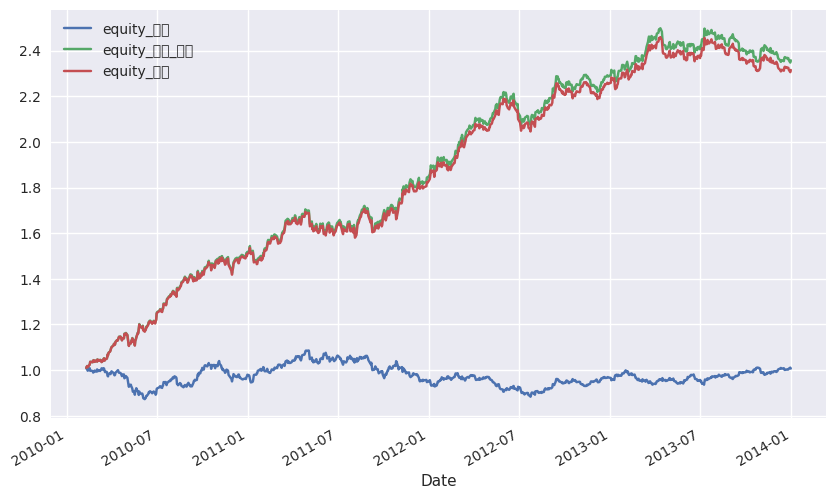

In [13]:
train['p'] = np.where(model.predict(train_[cols]) > 0.5, 1, 0)
print(train['p'])

def backtest(data, data_norm):
    data['pos'] = np.where(model.predict(data_norm[cols]) > 0.5, 1, 0)
    data['pos']=np.where(data['pos'] == 1, 1, -1)
    data['收益率_对数'] = data['pos'] * data['r']
    data['收益率'] = data['pos'] * data['r_']
    #data_bkt['收益率'] = data_bkt['pos'] * data_bkt['r_']
    data['equity_基准'] = data['r'].cumsum().apply(np.exp)
    #data_bkt['equity_策略'] = (data_bkt['收益率']+1).cumprod()
    data['equity_策略_对数'] = data['收益率_对数'].cumsum().apply(np.exp)
    data['equity_策略'] = (data['收益率']+1).cumprod()
    data[['equity_基准','equity_策略_对数','equity_策略']].plot(figsize=(10,6))


backtest(train,train_)

小结
我们仅使用了几个简单的因子“特征”，并建立简单的DNN模型，预测下一期的收益，可以获得超额收益。
未来的改进空间
- 更好的因子，更好的模型。